# Submitted by:

Name   : Mirza Kaazima Ifrah

Reg No : BL.EN.U4CSE18073 

## Bank Personal Loan Classification

Universal bank is a small but growing bank. The majority of customers are liability, or deposit only customers, and the bank is interested in converting more of them into asset, or borrowing, customers. The bank has had past success with marketing campaigns to convert the liability customers to personal loan customers. With that success, the bank is interested in being more targeted with its efforts to ensure marketing dollars are spent on those most likely to convert. The bank would like a model to help it predict which new customers are likely to become personal loan customers to aid in this targeting.

## Business Question

Can we predict which new customers are most likely to say yes to a personal loan?

## Import Necessary packages

In [ ]:
!pip install -U yellowbrick

In [ ]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Dataset Analysis

In [ ]:
bank_df = pd.read_csv('https://raw.githubusercontent.com/Nuthi-Sriram/Bank_Loan_Modelling/master/UniversalBank.csv')
bank_df.head()

ID  Age  Experience  ...  CD Account  Online  CreditCard
0   1   25           1  ...           0       0           0
1   2   45          19  ...           0       0           0
2   3   39          15  ...           0       0           0
3   4   35           9  ...           0       0           0
4   5   35           8  ...           0       0           1

[5 rows x 14 columns]

In [ ]:
# Drop columns that are not significant
bank_df = bank_df.drop(['ID', 'ZIP Code'], axis=1)
bank_df.head()

Age  Experience  Income  ...  CD Account  Online  CreditCard
0   25           1      49  ...           0       0           0
1   45          19      34  ...           0       0           0
2   39          15      11  ...           0       0           0
3   35           9     100  ...           0       0           0
4   35           8      45  ...           0       0           1

[5 rows x 12 columns]

In [ ]:
print('Shape:', bank_df.shape)

Shape: (5000, 12)


In [ ]:
bank_df['Personal Loan'].value_counts().rename_axis('Personal Loan').to_frame('No of customers')

No of customers
Personal Loan                 
0                         4520
1                          480

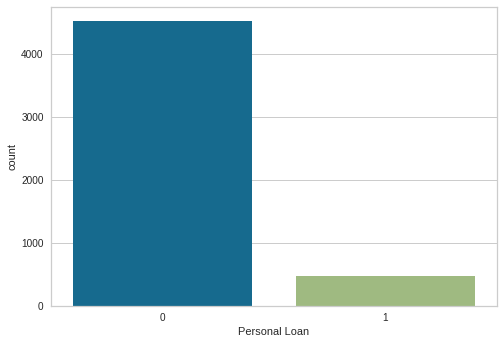

In [ ]:
sns.countplot(bank_df['Personal Loan'])



*   90.4% of the total customers do not take personal loan
*   9.6% of the total customers take personal loan
*   So, the dataset is skewed and we need to deal with this imbalanced dataset



## PCA

In [ ]:
feature = bank_df.copy().drop('Personal Loan', axis=1)
target = bank_df['Personal Loan']

In [ ]:
# Scale data to obtain zero mean and unit variance
scaler = StandardScaler()
feature = scaler.fit_transform(feature)

In [ ]:
# Generate covariance matrix, eigen values, and eigen vectors
features = feature.T
cov_mat = np.cov(features)
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)

In [ ]:
# Sorted array of indices
sorted_index = np.argsort(eigen_values)[::-1]
#sort the eigenvalues in descending order
sorted_eigenvalues = eigen_values[sorted_index]
print('Eigen values in descending order: ', sorted_eigenvalues)
# Sort the eigenvectors 
sorted_eigenvectors = eigen_vectors[:,sorted_index]

Eigen values in descending order:  [2.04891507 1.85678557 1.41461092 1.01636778 0.9975422  0.98367536
 0.92910531 0.89824755 0.51142457 0.34017265 0.00535346]


In [ ]:
total = sum(eigen_values)
explained_var = []
for value in sorted_eigenvalues:
  explained_var.append(np.round((value*100/total), decimals=2))
print('Sum of explained variances is: ', round(sum(explained_var))/100)
print('Explained variances (in %): ', explained_var)
print('Cumulative variances: ', list(np.round(np.cumsum(explained_var), decimals=2)))

Sum of explained variances is:  1.0
Explained variances (in %):  [18.62, 16.88, 12.86, 9.24, 9.07, 8.94, 8.44, 8.16, 4.65, 3.09, 0.05]
Cumulative variances:  [18.62, 35.5, 48.36, 57.6, 66.67, 75.61, 84.05, 92.21, 96.86, 99.95, 100.0]


Clearly, if we consider 6 principal components, then we can obtain a cumulative variance of around 76%

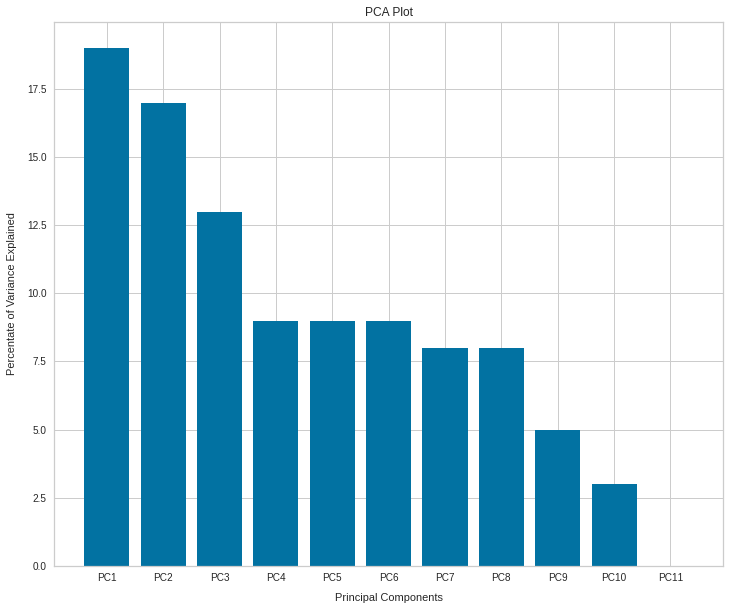

In [ ]:
percent_variance = [round(var) for var in explained_var]
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']
fig = plt.figure(figsize=(12, 10))
plt.bar(x= columns, height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained', labelpad=10)
plt.xlabel('Principal Components', labelpad=10)
plt.title('PCA Plot')
plt.show()

In [ ]:
# Consider number of components as 6
eigenvector_subset = sorted_eigenvectors[:,0:6]
# Transorm the original matrix
x_reduced = np.dot(feature, eigenvector_subset)

In [ ]:
# Create a Pandas DataFrame of reduced Dataset with 6 dimensions
x_reduced_df = pd.DataFrame(x_reduced , columns = ['PC1','PC2','PC3','PC4','PC5','PC6'])
# Concatenate it with target variable to create a complete dataset
x_reduced_df['Personal Loan'] = target
x_reduced_df.head()

PC1       PC2       PC3       PC4       PC5       PC6  Personal Loan
0 -2.002079 -1.635217 -1.062531 -2.137542  0.599147  1.938152              0
1  0.147811 -0.558268 -0.801336 -2.091811  0.391042  2.233492              0
2 -0.084117 -1.254918  0.942643  0.045140 -0.480842  1.570128              0
3 -1.362426 -0.267534  1.237181 -0.047862  0.126291  1.192668              0
4 -0.711365 -1.759962 -0.619391  1.470853  0.986634  0.610911              0

#### Final data with dimensionality reduction

In [ ]:
feature = x_reduced_df.drop(['Personal Loan'], axis=1)
feature.head()

PC1       PC2       PC3       PC4       PC5       PC6
0 -2.002079 -1.635217 -1.062531 -2.137542  0.599147  1.938152
1  0.147811 -0.558268 -0.801336 -2.091811  0.391042  2.233492
2 -0.084117 -1.254918  0.942643  0.045140 -0.480842  1.570128
3 -1.362426 -0.267534  1.237181 -0.047862  0.126291  1.192668
4 -0.711365 -1.759962 -0.619391  1.470853  0.986634  0.610911

## Plot the pricipal components

#### 1 dimension

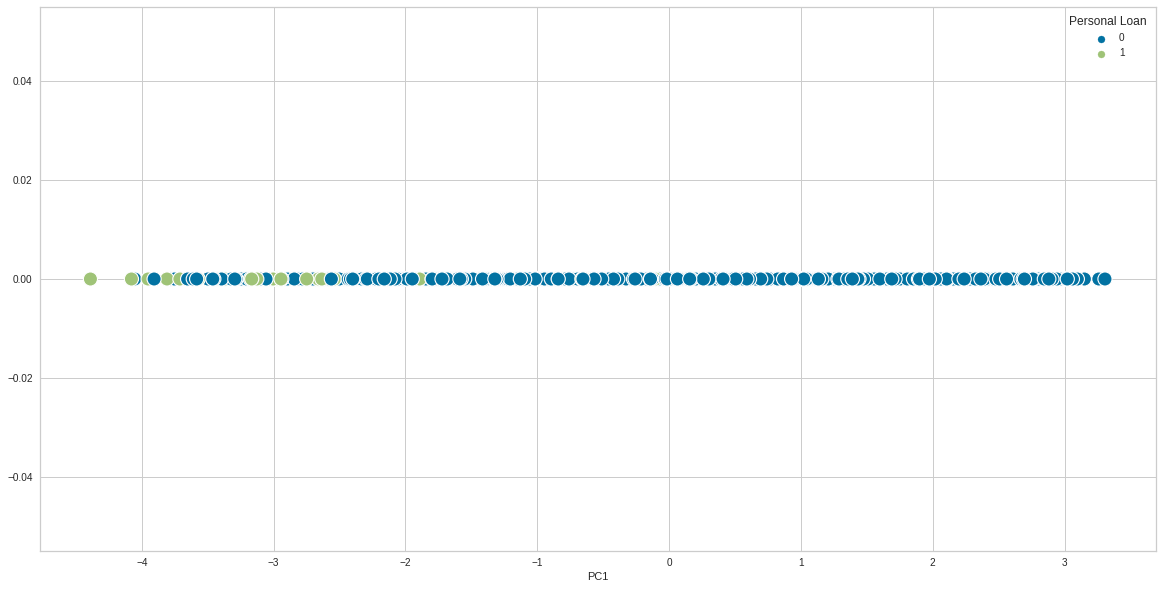

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x_reduced_df.PC1, [0] * len(x_reduced_df), hue=x_reduced_df['Personal Loan'], s=200)
plt.show()

#### 2 dimensions

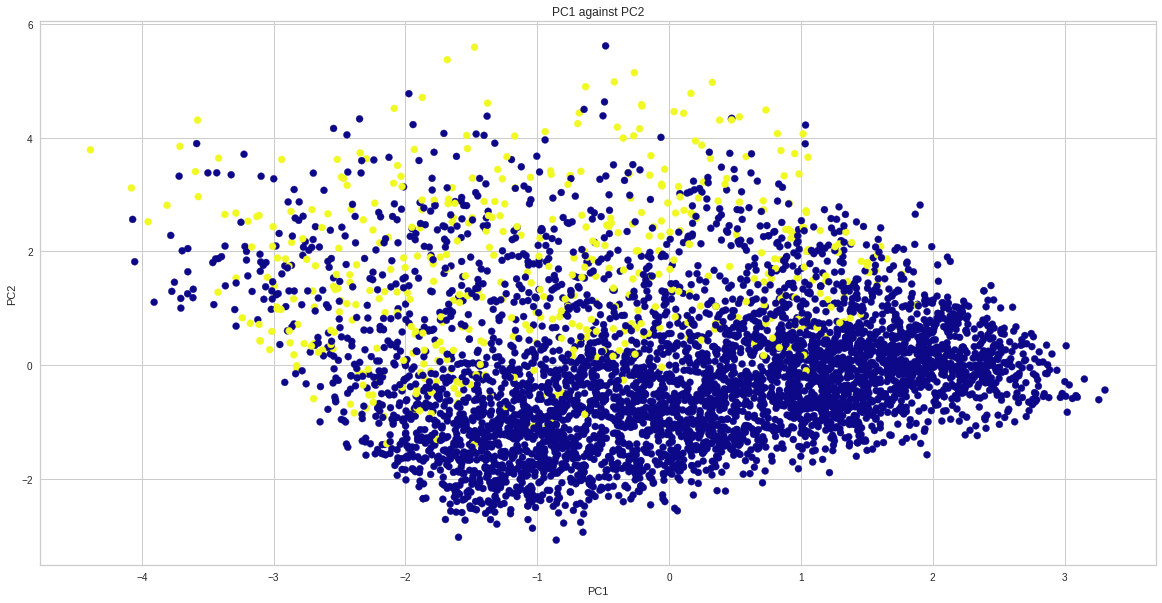

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x_reduced_df.PC1, x_reduced_df.PC2, c=x_reduced_df['Personal Loan'],cmap='plasma')
plt.title('PC1 against PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### 3 dimensions

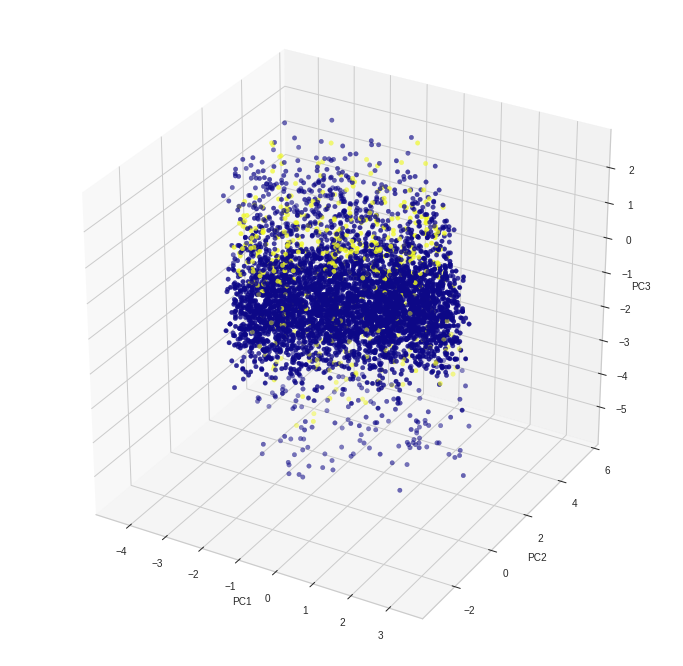

In [ ]:
fig = plt.figure(figsize=(12,12)) 
# Choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
axis.scatter(x_reduced_df.PC1,x_reduced_df.PC2,x_reduced_df.PC3, c=x_reduced_df['Personal Loan'],cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)
plt.show()

## Preprocessing the dataset

In [ ]:
# Balance the dataset by oversampling technique
smote = SMOTE(random_state = 10)
feature, target = smote.fit_sample(feature, target)

In [ ]:
print('Shape of feature :', feature.shape)
print('Shape of target  :', target.shape)

Shape of feature : (9040, 6)
Shape of target  : (9040,)


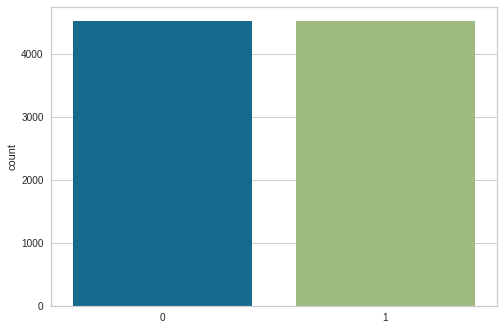

In [ ]:
sns.countplot(target)

## K-means Clustering

In [ ]:
# Create kmeans clustering object
kmeans = KMeans(n_clusters=2, random_state=42)

In [ ]:
t = time()
# Train the model
kmeans.fit(feature)
# Time is rounded to 3 decimal in seconds
print("Training time:", round(time()-t, 3), "s")

Training time: 0.166 s


In [ ]:
# Predict target value
pred = kmeans.predict(feature)

#### Performance of our model

In [ ]:
print("Accuracy:", accuracy_score(target, pred))

Accuracy: 0.6251106194690266


In [ ]:
# Manual way to find the accuracy

"""
import numpy as np
correct = 0
for i in range(1,len(feature)):
    predict_me = np.array(feature.iloc[i])
    predict_me = predict_me.reshape(-1, len(predict_me))
    prediction = kmeans.predict(predict_me)
    if prediction[0] == target[i]:
        correct += 1

print("Accuracy:", correct/len(feature))

"""

In [ ]:
# Checking performance of our model with classification report
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       0.57      0.96      0.72      4520
           1       0.89      0.29      0.43      4520

    accuracy                           0.63      9040
   macro avg       0.73      0.63      0.58      9040
weighted avg       0.73      0.63      0.58      9040



In [ ]:
# Checking performance of our model with ROC Score
print('ROC Score:', roc_auc_score(target, pred))

ROC Score: 0.6251106194690265


In [ ]:
# list the default parameters of the model
kmeans.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 2,
 'n_init': 10,
 'n_jobs': None,
 'precompute_distances': 'auto',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

## Hyper Parameter Tuning

In [ ]:
# List hyper parameters that we wish to tune
params = {'algorithm': ['auto', 'full', 'elkan'], 'n_clusters': list(range(2,5)), 'init': ['k-means++', 'random'], 'n_init': [10, 15, 20], 'max_iter': [300, 400, 500, 600], 'random_state': [42]}
# Use grid search
grid = GridSearchCV(kmeans, verbose=1, param_grid=params, scoring='accuracy', cv=10, n_jobs=-1)

In [ ]:
# Train the model
grid.fit(feature, target)
print()

Fitting 10 folds for each of 216 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  6.3min finished


In [ ]:
print('Best Score:', grid.best_score_)
print('Best Parameters:', grid.best_params_)

Best Score: 0.4745575221238939
Best Parameters: {'algorithm': 'auto', 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 2, 'n_init': 15, 'random_state': 42}


In [ ]:
best_kmeans = grid.best_estimator_
# print best hyper parameters
print(best_kmeans)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=15, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


In [ ]:
t = time()
# Train the model
best_kmeans.fit(feature, target)
# Time is rounded to 3 decimal in seconds
print("Training time:", round(time()-t, 3), "s")

Training time: 0.199 s


In [ ]:
# Predict target value
pred = best_kmeans.predict(feature)

In [ ]:
print("Accuracy:", accuracy_score(target, pred))

Accuracy: 0.6251106194690266


In [ ]:
# Print confusion matrix
print(confusion_matrix(target, pred))

[[4354  166]
 [3223 1297]]


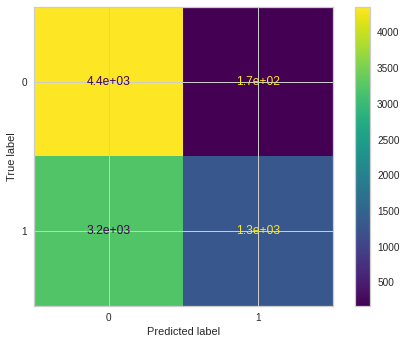

In [ ]:
# Plot confusion matrix
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(target, pred), display_labels=[0,1]).plot()

#### Performance of our model

In [ ]:
# Checking performance of our model with classification report
print(classification_report(target, pred))

              precision    recall  f1-score   support

           0       0.57      0.96      0.72      4520
           1       0.89      0.29      0.43      4520

    accuracy                           0.63      9040
   macro avg       0.73      0.63      0.58      9040
weighted avg       0.73      0.63      0.58      9040



In [ ]:
# Checking performance of our model with ROC Score
print('ROC Score:', roc_auc_score(target, pred))

ROC Score: 0.6251106194690265


# **Finding the Optimal number of clusters**

## Elbow Method

Reference: [Elbow method](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html)

#### Distortion scoring metric

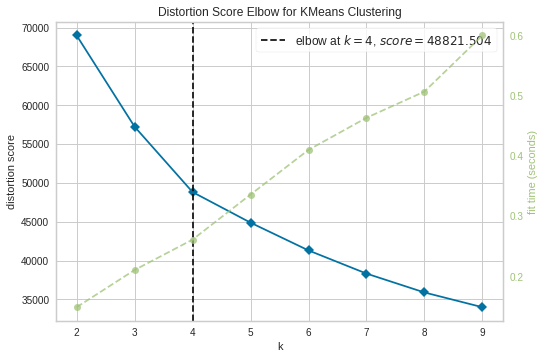

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))
visualizer.fit(feature)         # Fit the data to the visualizer
visualizer.poof()               # Finalize and render the figure

#### calinski_harabasz metric

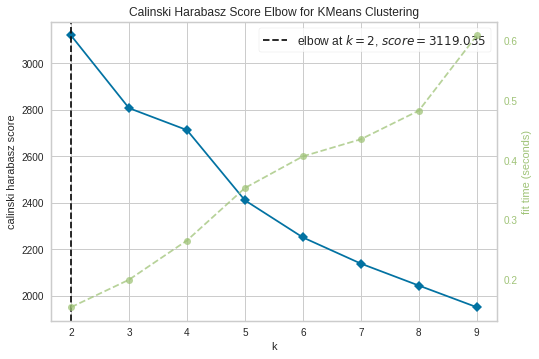

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric='calinski_harabasz')
visualizer.fit(feature)         # Fit the data to the visualizer
visualizer.poof()               # Finalize and render the figure

#### silhoutte metric

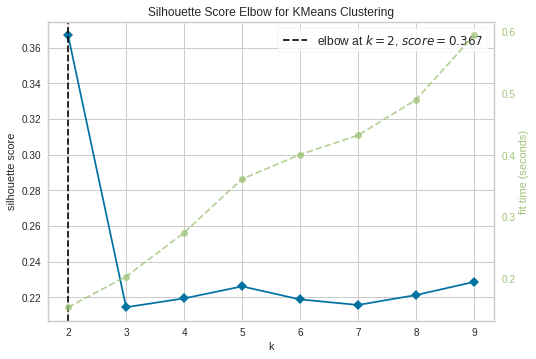

In [ ]:
# Instantiate the clustering model and visualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10), metric='silhouette')
visualizer.fit(feature)         # Fit the data to the visualizer
visualizer.poof()               # Finalize and render the figure silhouette

## Silhouette Visualizer

Reference: [Silhouette Visualizer](https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html)

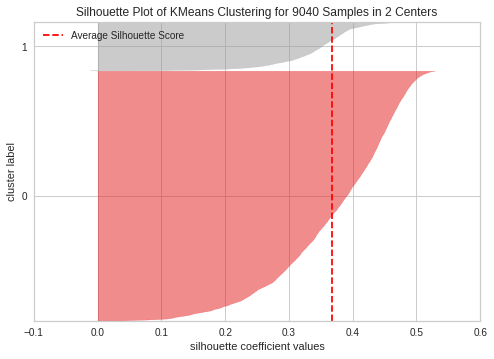

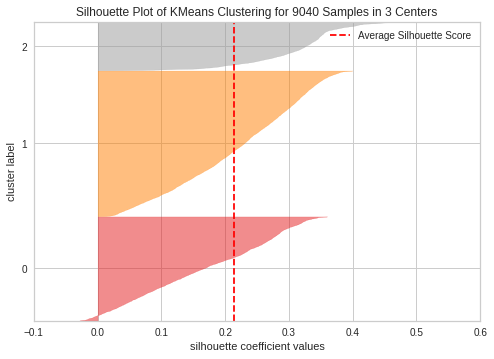

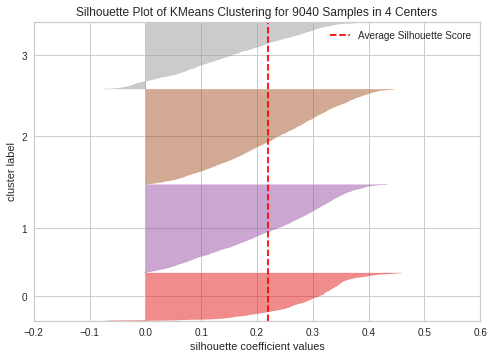

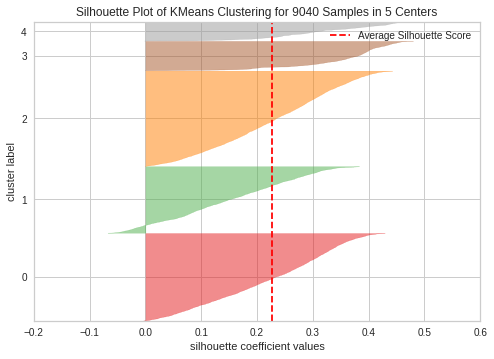

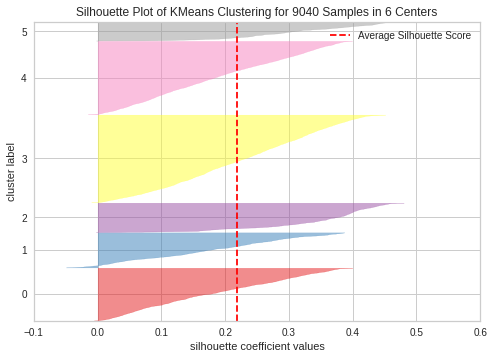

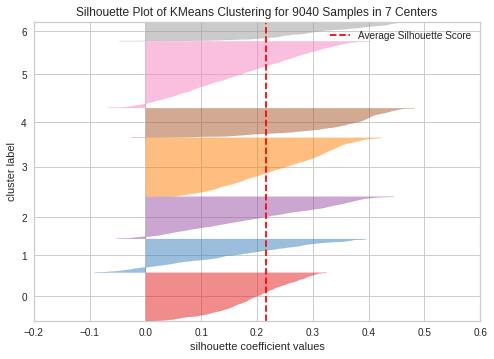

In [ ]:
from sklearn.metrics import silhouette_score
# Instantiate the clustering model and visualizer 
for i in range(2,8):
    model = KMeans(i, random_state=42)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(feature)     # Fit the data to the visualizer
    visualizer.poof()           # Draw/show/poof the data
    print()

## Intercluster Distance Maps

Reference: [Intercluster Distance Maps](https://www.scikit-yb.org/en/latest/api/cluster/icdm.html)


With 2 clusters:



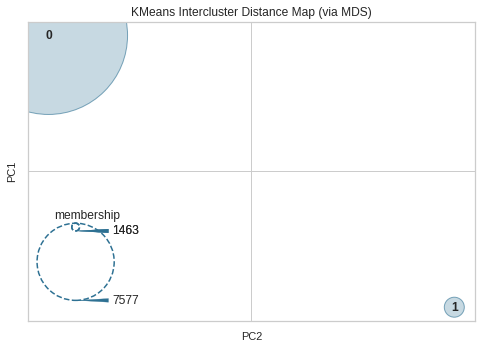


With 3 clusters:



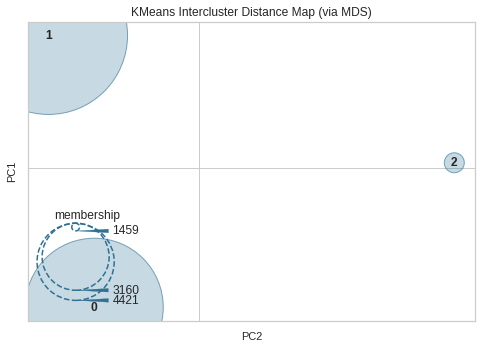


With 4 clusters:



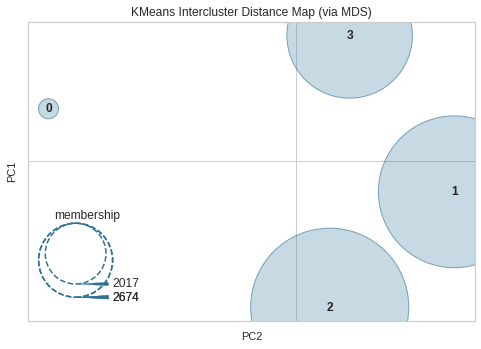


With 5 clusters:



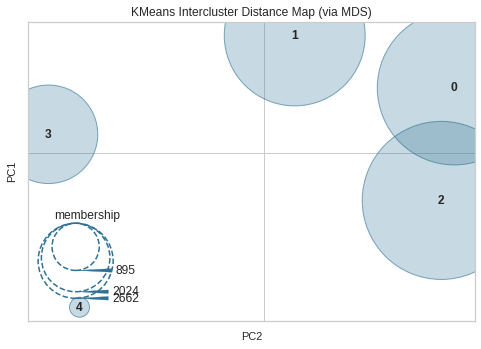


With 6 clusters:



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


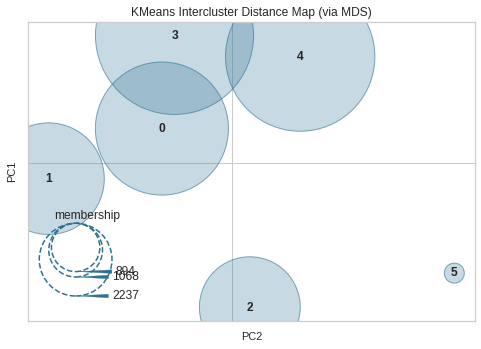


With 7 clusters:



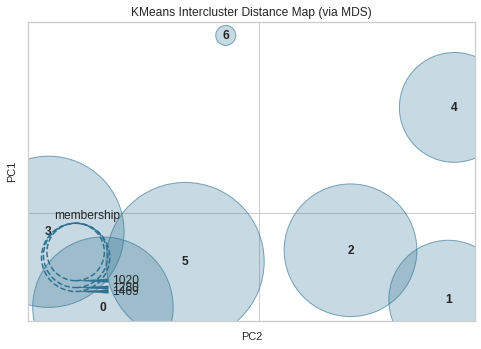

In [ ]:
# Instantiate the clustering model and visualizer 
for i in range(2,8):
    print("\nWith "+str(i)+" clusters:\n")
    model = KMeans(i, random_state=42)
    visualizer = InterclusterDistance(model)
    visualizer.fit(feature)     # Fit the data to the visualizer
    visualizer.poof()           # Draw/show/poof the data
    

## Overall Analysis



*   Applying PCA improved the performance of the model. It gave good accuracy as well as good ROC compared to the original dataset.

*   Similarly, after upsampling using SMOTE, there is a good improvement in performance metrics like accuracy, ROC score, etc

*   Likewise, without upsampling, elbow method gave the no of clusters as 4 (tried this in a different notebook), which is not correct. After upsampling, no of clusters is 2, which is a correct value (personal loan - yes/no).

